## Get data from TWS API

In [2]:
from ib_insync import *
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import datetime as dt
util.startLoop()

In [3]:
# Connect to TWS API
ib = IB()
ib.connect()    
# ib.positions()

<IB connected to 127.0.0.1:7497 clientId=1>

In [89]:
# ib.disconnect()

In [4]:
contract = Forex('EURUSD')

In [19]:
def onBarUpdate(bars, hasnewBar):
    global df 
    df = pd.DataFrame(bars)[['date', 'close', 'volume']].iloc[:-1] # only take the date and closing price, execute the last row
    df.set_index('date', inplace = True) 
    clear_output(wait=True)
    display(df)

In [20]:
bars = ib.reqHistoricalData(
    contract,
    endDateTime='', # current data
    durationStr='1 Y',
    barSizeSetting='1 day',
    whatToShow='ASK',
    useRTH=True,
    formatDate=2,
    keepUpToDate=True,
    timeout = 0
)

In [21]:
# stream data
bars.updateEvent += onBarUpdate 

,close,volume
date,,
2023-07-18,1.12285,-1.0
2023-07-19,1.12010,-1.0
2023-07-20,1.11298,-1.0
2023-07-21,1.11289,-1.0
2023-07-24,1.10650,-1.0
...,...,...
2024-07-09,1.08138,-1.0
2024-07-10,1.08303,-1.0
2024-07-11,1.08685,-1.0


In [ ]:
ib.cancelHistoricalData(bars)

Error 366, reqId 91: No historical data query found for ticker id:91


In [ ]:
df

,close,volume
date,,
2023-07-18,1.12285,-1.0
2023-07-19,1.12010,-1.0
2023-07-20,1.11298,-1.0
2023-07-21,1.11289,-1.0
2023-07-24,1.10650,-1.0
...,...,...
2024-07-09,1.08138,-1.0
2024-07-10,1.08303,-1.0
2024-07-11,1.08685,-1.0


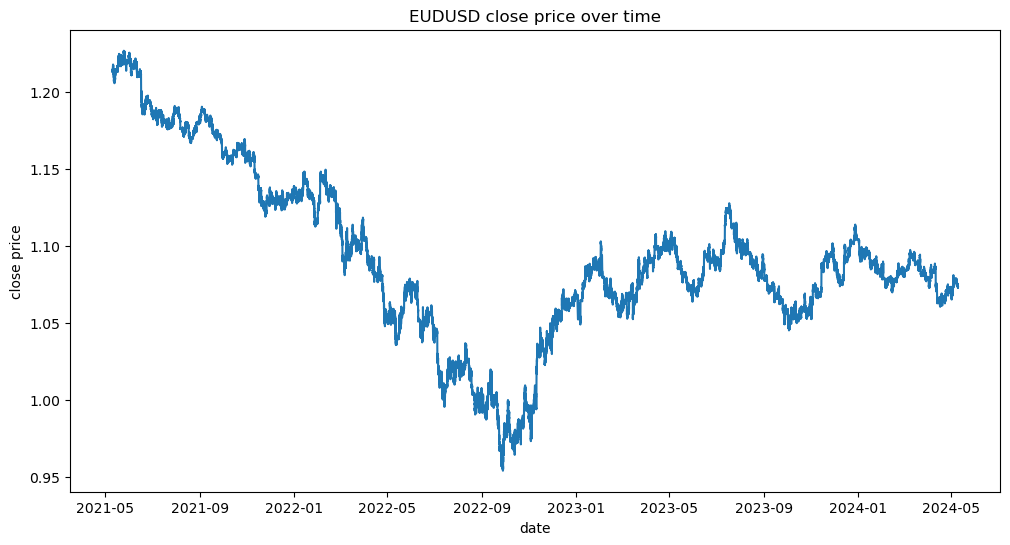

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,6))
plt.plot(df.index, df['close'],linestyle = '-')
plt.title('EUDUSD close price over time')
plt.xlabel('date')
plt.ylabel('close price')
plt.show()

- General trend: share decline from mid-2021 to early 2022, followed by a substantial recovery that peaks around mid-2023. Afterwards, EUR/USD pair appears to show a fluctuating yet slightly downward trend towards early 2024
- Volatility: significant volatility, driven by economic policy changes, geopolitical events, and market sentiment
- Resistance levels: possible levels where price has historically reversed or slowed its trend

In [14]:
# df.to_csv('eurusd.csv')

## Import data

In [3]:
df = pd.read_csv('eurusd.csv')
df['date'] = pd.to_datetime(df['date'])
df['close_mul'] = df['close']*100000 # scale up the price
df.set_index('date', inplace = True)
df

,close,close_mul
date,,
2021-05-10 21:15:00+00:00,1.21297,121297.0
2021-05-10 21:20:00+00:00,1.21305,121305.0
2021-05-10 21:25:00+00:00,1.21295,121295.0
2021-05-10 21:30:00+00:00,1.21295,121295.0
2021-05-10 21:35:00+00:00,1.21305,121305.0
...,...,...
2024-05-09 10:45:00+00:00,1.07347,107347.0
2024-05-09 10:50:00+00:00,1.07349,107349.0
2024-05-09 10:55:00+00:00,1.07347,107347.0


## Create Lag Features

In [4]:
data_model = pd.DataFrame()
data_model['price'] = df['close_mul']
data_model['target'] = df['close_mul'].shift(-4) - df['close_mul'] 
for i in range(5):
    data_model[f'lag_{i}'] = df['close_mul'].shift(i) - df['close_mul'].shift(i+1) # lagged feature
for i in range(5):
    data_model[f'ret_{i}'] = df['close_mul'] - df['close_mul'].shift(i+1) # return feature
data_model.dropna(inplace=True)
data_model.index = pd.to_datetime(data_model.index)
data_model

,price,target,lag_0,lag_1,lag_2,lag_3,lag_4,ret_0,ret_1,ret_2,ret_3,ret_4
date,,,,,,,,,,,,
2021-05-10 21:40:00+00:00,121305.0,28.0,0.0,10.0,0.0,-10.0,8.0,0.0,10.0,10.0,0.0,8.0
2021-05-10 21:45:00+00:00,121310.0,5.0,5.0,0.0,10.0,0.0,-10.0,5.0,5.0,15.0,15.0,5.0
2021-05-10 21:50:00+00:00,121310.0,4.0,0.0,5.0,0.0,10.0,0.0,0.0,5.0,5.0,15.0,15.0
2021-05-10 21:55:00+00:00,121308.0,11.0,-2.0,0.0,5.0,0.0,10.0,-2.0,-2.0,3.0,3.0,13.0
2021-05-10 22:00:00+00:00,121333.0,26.0,25.0,-2.0,0.0,5.0,0.0,25.0,23.0,23.0,28.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-09 10:25:00+00:00,107360.0,-13.0,6.0,0.0,-26.0,21.0,20.0,6.0,6.0,-20.0,1.0,21.0
2024-05-09 10:30:00+00:00,107365.0,-16.0,5.0,6.0,0.0,-26.0,21.0,5.0,11.0,11.0,-15.0,6.0
2024-05-09 10:35:00+00:00,107371.0,-24.0,6.0,5.0,6.0,0.0,-26.0,6.0,11.0,17.0,17.0,-9.0


In [5]:
from sklearn.linear_model import *
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

In [8]:
def backtest_price(price_series, position_series):
    bt = pd.DataFrame(price_series.diff() * position_series.shift()) # simulate trading strategy based on postion in previous period
    bt['Date'] = [str(i)[:10] for i in bt.index]
    daily_pnl = bt.groupby('Date').sum()
    # calculate Sharpe ratio, Maximum drawdown
    return (daily_pnl.mean()/daily_pnl.std()*np.sqrt(252))[0], (daily_pnl.cummax() - daily_pnl.cumsum()).max()/price_series.max()

## Fit/Evaluate the model

In [9]:
# Model initiation
np.random.seed(42)
f_names = list(data_model)[2:]
model = Lasso(alpha=0.1)
X = data_model[f_names]
y = data_model['price'].shift(-4) - data_model['price']
y_price = data_model['price']

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

sharpe = []
max_drawdown = []
accuracy_scores = []
for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    y_price_train, y_price_test = y_price.iloc[train_index], y_price.iloc[val_index]

    model.fit(X_train, y_train)
    
    y_pred = pd.Series(model.predict(X_val), index=X_val.index)
    y_pred_direction = (y_pred > 0).astype(int)
    y_true_direction = (y_val > 0).astype(int)
    
    accuracy = accuracy_score(y_true_direction, y_pred_direction)
    accuracy_scores.append(accuracy)
    
    strategy_positions = y_pred_direction
    sharpe_ratio, max_dd = backtest_price(y_price_test, strategy_positions)
    sharpe.append(sharpe_ratio)
    max_drawdown.append(max_dd)

mean_sharpe = np.mean(sharpe)
mean_max_drawdown = np.mean(max_drawdown)
mean_accuracy = np.mean(accuracy_scores)

print(f"Mean Sharpe Ratio: {mean_sharpe}")
print(f"Mean Maximum Drawdown: {mean_max_drawdown}")
print(f"Mean Accuracy: {mean_accuracy}")

Mean Sharpe Ratio: 1.5678928508194214
Mean Maximum Drawdown: 0.010035202029223316
Mean Accuracy: 0.5099951348721554


In [7]:
f_names

['lag_0',
 'lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'ret_0',
 'ret_1',
 'ret_2',
 'ret_3',
 'ret_4']

In [8]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(184994, 10)
(36998, 10)
(184994,)
(36998,)


## Hyperparameters tuning

In [11]:
# fine-tuning function
def tuning(window, alpha, n_features_used):
    np.random.seed(42)
    f_names1 = f_names[:n_features_used]
    model = Lasso(alpha = alpha)
    X = data_model[f_names1]
    y = data_model['price'].shift(-window) - data_model['price']
    y_price = data_model['price']

    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    sharpe = []
    max_drawdown = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        y_price_train, y_price_test = y_price.iloc[train_index], y_price.iloc[val_index]
        model.fit(X_train, y_train)
        y_pred = (pd.Series(model.predict(X_val)) > 0).astype(int)
        y_pred.index = y_price_test.index
        accuracy = backtest_price(y_price_test, (y_pred > 0).astype(int))
        sharpe.append(accuracy[0])
        max_drawdown.append(accuracy[1])
    return np.mean(sharpe), np.mean(max_drawdown)

In [12]:
# test function
tuning(5, 0.1, 10)

(1.4338333360563218, 0.00893364722642335)

In [21]:
# choose best params
from itertools import product
window = list(range(2, 11))
alpha = [0.1 * i for i in range(1, 10)]
n_features_used = list(range(2, 11))

hyperparams = list(product(window, alpha, n_features_used))

df_tuned = pd.DataFrame(hyperparams, columns=['window', 'alpha', 'n_features_used'])

df_tuned['sharpe'] = [(tuning(df_tuned['window'].iloc[i], df_tuned['alpha'].iloc[i], df_tuned['n_features_used'].iloc[i]))[0] for i in range(len(df_tuned))]
df_tuned['max_dd'] = [(tuning(df_tuned['window'].iloc[i], df_tuned['alpha'].iloc[i], df_tuned['n_features_used'].iloc[i]))[1] for i in range(len(df_tuned))]
df_sorted = df_tuned.sort_values('sharpe', ascending=False)
print(df_sorted)

     window  alpha  n_features_used    sharpe    max_dd
209       4    0.6                4  1.829658  0.008061
182       4    0.3                4  1.828895  0.008333
200       4    0.5                4  1.822617  0.008081
191       4    0.4                4  1.814004  0.008342
236       4    0.9                4  1.810835  0.008375
..      ...    ...              ...       ...       ...
641       9    0.9                4  1.050671  0.011719
541       8    0.7                3  1.011206  0.013873
550       8    0.8                3  1.008409  0.013736
532       8    0.6                3  1.004597  0.013709
559       8    0.9                3  0.963431  0.013648

[729 rows x 5 columns]


- Best params: window = 4, regularization alpha = 0.6, number of features = 4

In [14]:
# create function for pulling out training/testing data model
def generate_data(data_train):
    data_model = pd.DataFrame()
    data_model['price'] = data_train['close_mul']
    data_model['target'] = data_train['close_mul'].shift(-4) - data_train['close_mul']
    for i in range(5):
      data_model['lag_'+str(i)] = data_train['close_mul'].shift(i) - data_train['close_mul'].shift(i+1)
    for i in range(5):
      data_model['ret_'+str(i)] = data_train['close_mul'] - data_train['close_mul'].shift(i+1)
    data_model.dropna(inplace = True)
    return data_model

In [15]:
# TimeSeriesSplit
data_model_train = df.iloc[:184994]
data_model_test = df.iloc[184994:]

In [16]:
# pull out training data
train_data = generate_data(data_model_train)

## Fit the model with best params

In [17]:
# fit the model with training set
alpha = 0.6
window = 4
n_features_used = 4
f_names1 = f_names[:n_features_used]
X = train_data[f_names1]
y = train_data['price'].shift(-window) - train_data['price']
y_price = train_data['price']
model = Lasso(alpha=alpha)
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    y_price_train, y_price_test = y_price.iloc[train_index], y_price.iloc[val_index]
model.fit(X_train, y_train)

Lasso(alpha=0.6)

In [18]:
def backtest_position(position, price):
    pos = pd.Series(position)
    pr = pd.Series(price)

    pos_long = np.where(pos>0, pos, 0)
    pos_short = np.where(pos<0, pos, 0)
    pnl_long = (pr.shift(-1)-pr) * pos_long
    pnl_short = (pr.shift(-1)-pr) * pos_short

    return pnl_long + pnl_short

## Backtesting

<AxesSubplot:xlabel='Date'>

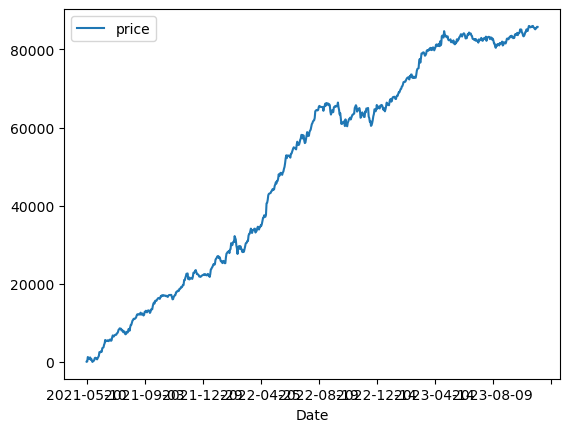

In [19]:
# backtesting on train data
train_data['target_prediction'] = model.predict(train_data[f_names1])
train_data['position'] = (train_data['target_prediction']>0).astype(int).replace(0,-1) # positive predictions in long, negative in short
backtest = backtest_position(train_data['position'], train_data['price'])
bt = pd.DataFrame(backtest)
bt['Date'] = [str(i)[:10] for i in bt.index]
bt.groupby('Date').sum().cumsum().plot()

In [20]:
# get test data
test_data = generate_data(data_model_test)

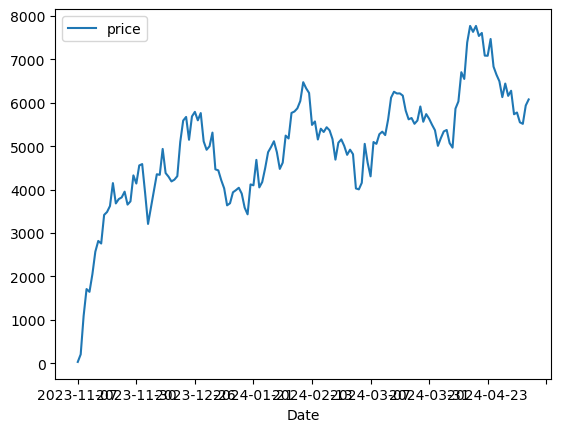

In [21]:
import matplotlib.pyplot as plt
# backtesting on test data
test_data['target_prediction'] = model.predict(test_data[f_names1])
test_data['position'] = (test_data['target_prediction'] > 0).astype(int).replace(0, -1)
backtest = backtest_position(test_data['position'], test_data['price'])
bt = pd.DataFrame(backtest)
bt['Date'] = [str(i)[:10] for i in bt.index]
bt.groupby('Date').sum().cumsum().plot()
plt.show()

- The test backtest results capture more recent data and show short-term volatility, which is expected given the smaller time frame
- The test backtest may better reflect current market sentiment, whereas the train backtest results represent a more smoothed long-term historical view

In [22]:
test_data

,price,target,lag_0,lag_1,lag_2,lag_3,lag_4,ret_0,ret_1,ret_2,ret_3,ret_4,target_prediction,position
date,,,,,,,,,,,,,,
2023-11-07 10:40:00+00:00,106846.0,-20.0,-35.0,-54.0,-27.0,15.0,44.0,-35.0,-89.0,-116.0,-101.0,-57.0,2.007266,1
2023-11-07 10:45:00+00:00,106849.0,-25.0,3.0,-35.0,-54.0,-27.0,15.0,3.0,-32.0,-86.0,-113.0,-98.0,1.568320,1
2023-11-07 10:50:00+00:00,106812.0,-11.0,-37.0,3.0,-35.0,-54.0,-27.0,-37.0,-34.0,-69.0,-123.0,-150.0,2.435363,1
2023-11-07 10:55:00+00:00,106816.0,-50.0,4.0,-37.0,3.0,-35.0,-54.0,4.0,-33.0,-30.0,-65.0,-119.0,0.687490,1
2023-11-07 11:00:00+00:00,106826.0,-54.0,10.0,4.0,-37.0,3.0,-35.0,10.0,14.0,-23.0,-20.0,-55.0,-0.185181,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-09 10:25:00+00:00,107360.0,-13.0,6.0,0.0,-26.0,21.0,20.0,6.0,6.0,-20.0,1.0,21.0,-0.487964,-1
2024-05-09 10:30:00+00:00,107365.0,-16.0,5.0,6.0,0.0,-26.0,21.0,5.0,11.0,11.0,-15.0,6.0,-0.200371,-1
2024-05-09 10:35:00+00:00,107371.0,-24.0,6.0,5.0,6.0,0.0,-26.0,6.0,11.0,17.0,17.0,-9.0,-0.780507,-1


In [23]:
from joblib import dump
file_path = 'lasso_model.joblib'
dump(model, file_path)

['lasso_model.joblib']

In [24]:
test_data['position'].value_counts()

position
-1    26260
 1    10738
Name: count, dtype: int64